In [1]:
import os, sys
import torch, json
import numpy as np

from detr_utils import build_model
from dino_utils.slconfig import SLConfig
from dataset_utils.coco import build_dataset
from dino_utils.visualizer import COCOVisualizer
from dino_utils import box_ops
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [107]:
# adapted from https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb#scrollTo=eg4RK8JiYTEl
import torchvision.transforms as T
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).cuda()
    return b

def visualize_decoder_weights(model, img):
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
    ]
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    # mean-std normalize the input image (batch-size: 1)
    #img = transform(im).unsqueeze(0)

    # propagate through the model
    outputs = model(img.unsqueeze(0).cuda())

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9

    # convert boxes from [0; 1] to image scales
    print("Size is", img.shape)
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], (img.shape[2], img.shape[1]))
    
    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, inp, output: conv_features.append(output)
        ),
        model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
            lambda self, inp, output: enc_attn_weights.append(output[1])
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, inp, output: dec_attn_weights.append(output[1])
        ),
    ]
    
    # propagate through the model
    outputs = model(img.unsqueeze(0).cuda())

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]
    
    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]

    print("There are", len(bboxes_scaled), "objects in the figure")
    print("And there are", len(keep.nonzero()), "class indices")
    plt.clf()
    fig, ax = plt.subplots(ncols=2, nrows=len(bboxes_scaled), figsize=(2*5, len(bboxes_scaled) * 5))
    colors = COLORS * 100
    i = 0
    for idx, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), bboxes_scaled.detach().cpu().numpy()):
        if len(bboxes_scaled) > 1:
    #         ax = ax_i[0]
            ax[i,0].imshow(dec_attn_weights[0, idx].view(h, w).detach().cpu().numpy())
            ax[i,0].axis('off')
            ax[i,0].set_title(f'query id: {idx.item()}')
            #ax = ax_i[1]
            ax[i,1].imshow(img.permute(1, 2, 0))
            ax[i,1].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color='blue', linewidth=3))
            ax[i,1].axis('off')
            ax[i,1].set_title(CLASSES[probas[idx].argmax()])
            i += 1
        else:
            ax[0].imshow(dec_attn_weights[0, idx].view(h, w).detach().cpu().numpy())
            ax[0].axis('off')
            ax[0].set_title(f'query id: {idx.item()}')
            #ax = ax_i[1]
            ax[1].imshow(img.permute(1, 2, 0))
            ax[1].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color='blue', linewidth=3))
            ax[1].axis('off')
            ax[1].set_title(CLASSES[probas[idx].argmax()])
            i += 1
    fig.tight_layout()
    plt.show()
    
    

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
--- NORMAL IMAGE ---
Size is torch.Size([3, 800, 1060])
There are 5 objects in the figure
And there are 5 class indices


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


<Figure size 640x480 with 0 Axes>

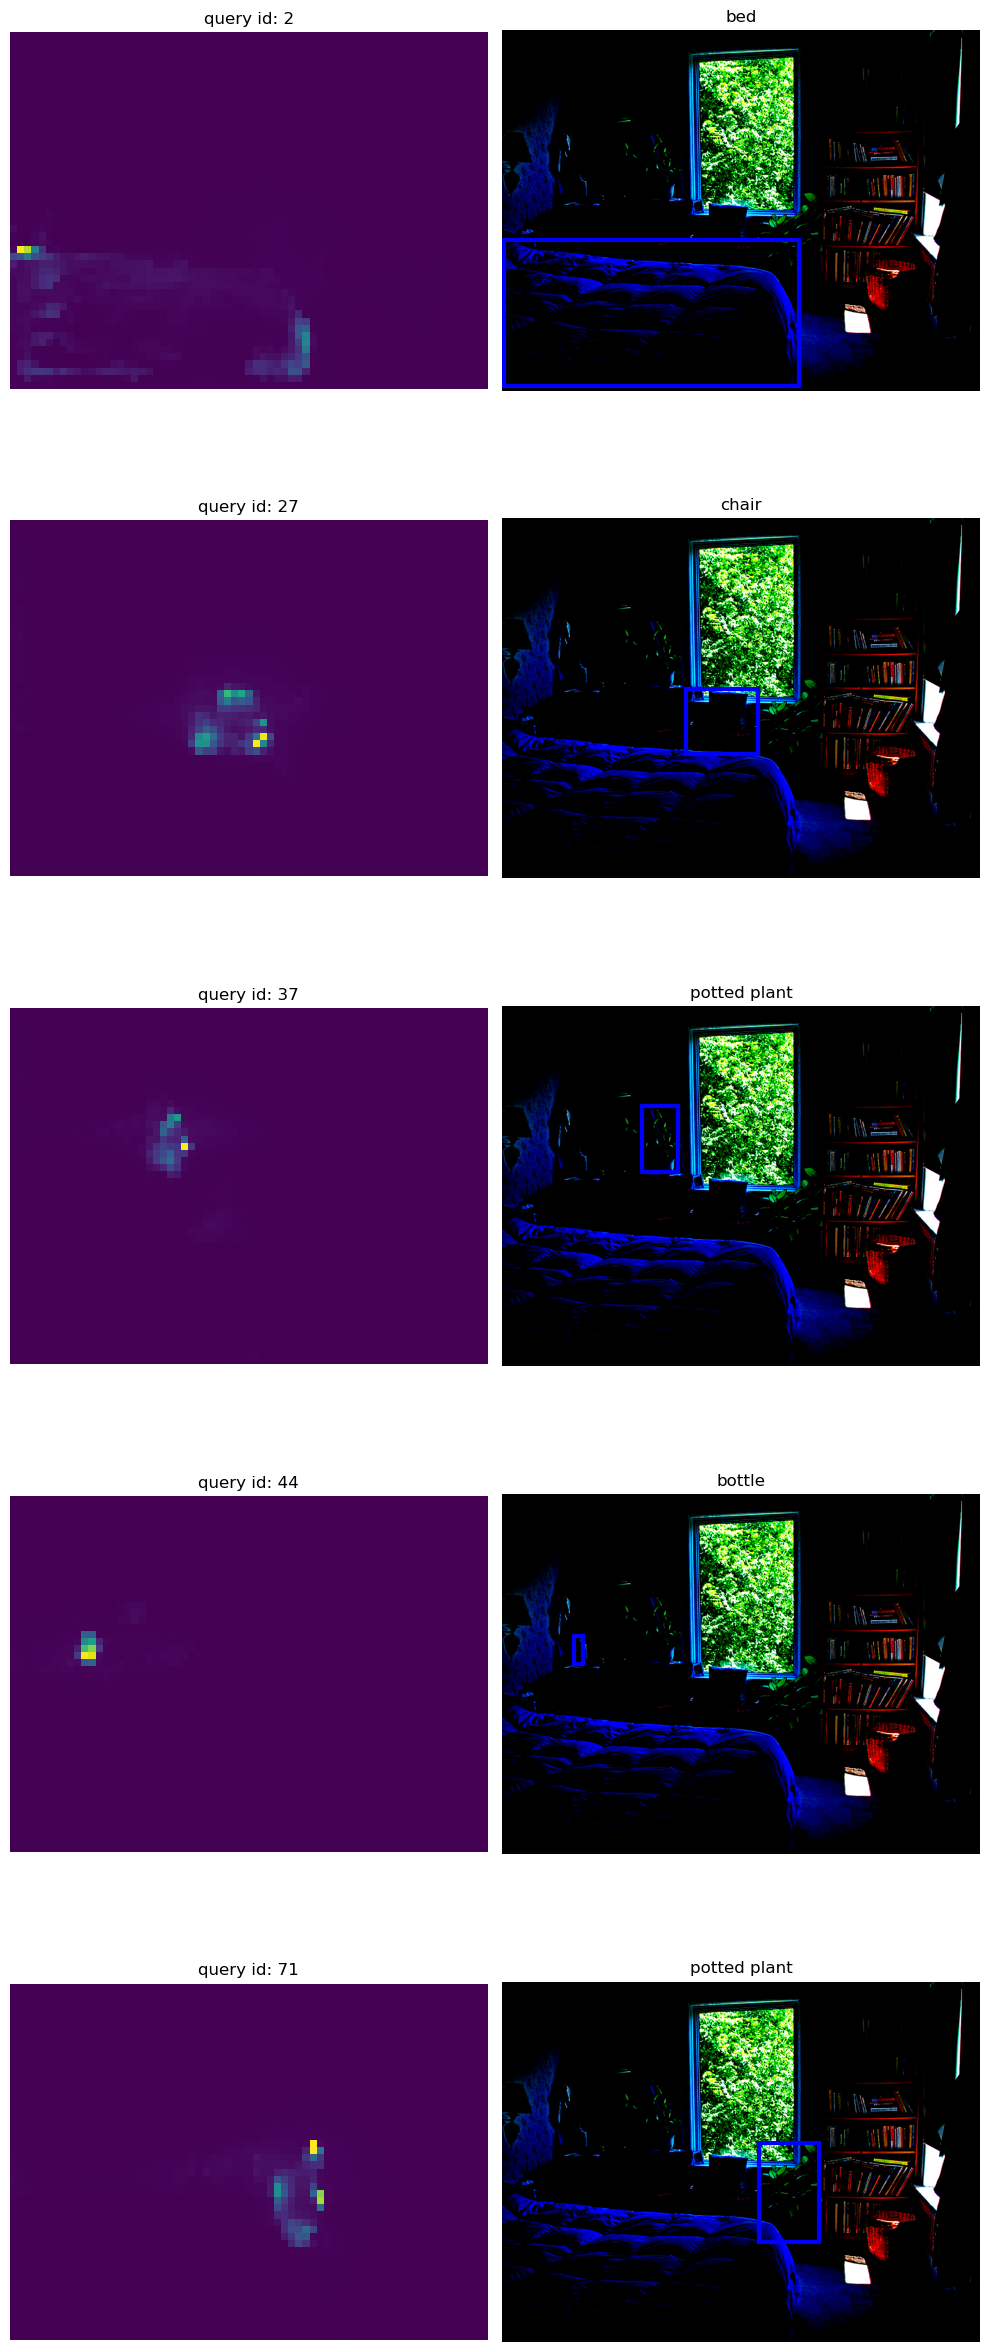

--- ATTACKED ---


In [ ]:
model_config_path = "detr_utils/config/r50_config.py"
model_checkpoint_path = "model_files/detr-r50.pth"
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda'
args.masks = False
args.resume="resnet50"
model, criterion, postprocessors = build_model(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu', weights_only=True)
_ = model.eval()
model.postprocessors = postprocessors
model.load_state_dict(checkpoint['model'])
model.to(torch.device('cuda'))
model.criterion = criterion
# load coco names
with open('dino_utils/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}
    
args.dataset_file = 'coco'
args.coco_path = "dataset/coco/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

print("--- NORMAL IMAGE ---")
image, targets = dataset_val[2]
visualize_decoder_weights(model, image)

print("--- ATTACKED ---")
from tog.attacks import tog_attention
image_attn = tog_attention(model, image.unsqueeze(0).float(), n_iter=10, mode="vanishing")
visualize_decoder_weights(model, image_attn.squeeze().float())